In [1]:
from numpy.random import Generator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize 
from scipy.stats import gaussian_kde
from scipy.stats import ks_2samp
from scipy.special import rel_entr
import scipy

In [2]:
try:
    plt.style.use('neuroblu')
except:
    print('neuroblu style not found. Using default style!')

neuroblu style not found. Using default style!


In [3]:
def cohensd(d1, d2):
    cohens_d = (np.mean(d1) - np.mean(d2)) / (np.sqrt((np.std(d1) ** 2 + np.std(d2) ** 2) / 2))
    return cohens_d

In [4]:
config = {
    'nbase': 100,
    'neca': 500,
    'nwaypoints': 20,
    'optimizeon': 'rel_entr'
}

In [5]:
def plot_dist(data1, data2, col, ax=None):
    if not ax:
        _, ax = plt.subplots(1,1)
        
    ax.hist(data1[col], density=True, fill='black', histtype='stepfilled', 
             edgecolor='black', bins= 10, linewidth=1.2, label=data1.name)
    ax.hist(data2[col], density=True, bins= 10, fill='blue', histtype='stepfilled',
             edgecolor='blue', linewidth=1.2, label=data2.name, alpha=0.7)
    ax.legend(loc='best')
    ax.set_title(col)
    return 

In [6]:
# For Base cohort
age = 45
lab1 = 3.4
lab2 = 5000

mean = [age, lab1, lab2]
cov = [[14, 3, 100], 
       [3, 2, 50],
       [100, 50, 25000]]

np.random.seed(42)
x = np.random.multivariate_normal(mean, cov, config['nbase'])
x[x< 0] = 0

lab3 = np.random.beta(1, 2, size=config['nbase'])
x = np.concatenate((x, lab3.reshape(config['nbase'], -1)), axis=1)

cond1 = np.random.binomial(1, 0.3, size=config['nbase']).reshape(config['nbase'], -1)
x = np.concatenate((x, cond1), axis=1)

cat1 = np.random.binomial(3, 0.5, size=config['nbase']).reshape(config['nbase'], -1)
x = np.concatenate((x, cat1), axis=1)

data_base = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3', 'cond1', 'cat1'])

In [7]:
# For External cohort
age = 50
lab1 = 5.5
lab2 = 4800

mean = [age, lab1, lab2]
cov = [[20, 5, 150], 
       [5, 4, 100],
       [150, 100, 55000]]

x = np.random.multivariate_normal(mean, cov, config['neca'])
x[x< 0] = 0

lab3 = 1.5*np.random.beta(1, 2, size=config['neca'])
x = np.concatenate((x, lab3.reshape(config['neca'], -1)), axis=1)

cond1 = np.random.binomial(1, 0.5, size=config['neca']).reshape(config['neca'], -1)
x = np.concatenate((x, cond1), axis=1)

cat1 = np.random.binomial(3, 0.7, size=config['neca']).reshape(config['neca'], -1)
x = np.concatenate((x, cat1), axis=1)

data_eca = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3', 'cond1', 'cat1'])

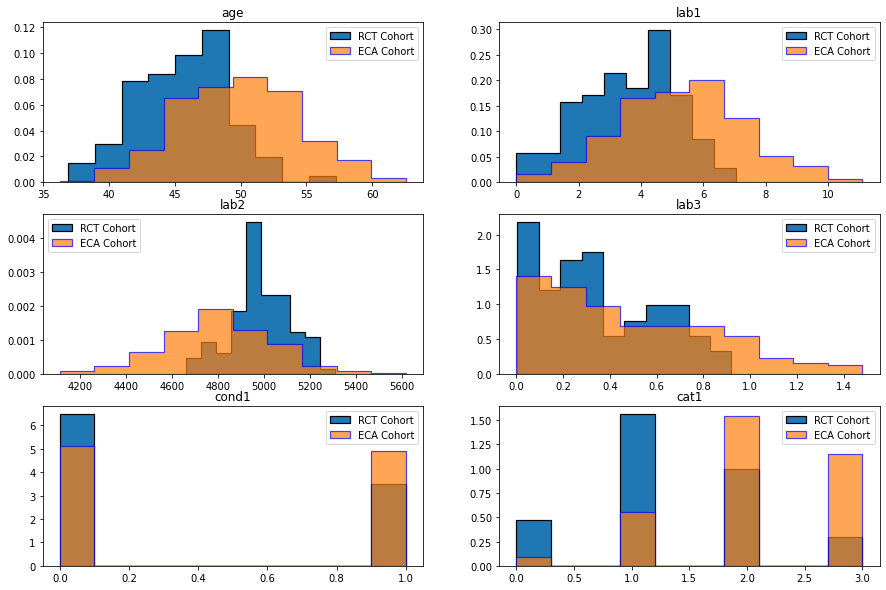

In [8]:
_, ax = plt.subplots(3,2, figsize=(15, 10))

data_base.name = 'RCT Cohort'
data_eca.name = 'ECA Cohort'
plot_dist(data_base, data_eca, 'age', ax[0][0])
plot_dist(data_base, data_eca, 'lab1', ax[0][1])
plot_dist(data_base, data_eca, 'lab2', ax[1][0])
plot_dist(data_base, data_eca, 'lab3', ax[1][1])
plot_dist(data_base, data_eca, 'cond1', ax[2][0])
plot_dist(data_base, data_eca, 'cat1', ax[2][1])

In [9]:
density_age = gaussian_kde(data_base['age'])
density_lab1 = gaussian_kde(data_base['lab1'])
density_lab2 = gaussian_kde(data_base['lab2'])
density_lab3 = gaussian_kde(data_base['lab3'])
density_cond1 = gaussian_kde(data_base['cond1'])
density_cat1 = gaussian_kde(data_base['cat1'])

In [10]:
b = max(data_base['age'].max(), data_eca['age'].max())
a = min(data_base['age'].min(), data_eca['age'].min())
waypoints_age = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['lab1'].max(), data_eca['lab1'].max())
a = min(data_base['lab1'].min(), data_eca['lab1'].min())
waypoints_lab1 = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['lab2'].max(), data_eca['lab2'].max())
a = min(data_base['lab2'].min(), data_eca['lab2'].min())
waypoints_lab2 = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['lab3'].max(), data_eca['lab3'].max())
a = min(data_base['lab3'].min(), data_eca['lab3'].min())
waypoints_lab3 = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['cond1'].max(), data_eca['cond1'].max())
a = min(data_base['cond1'].min(), data_eca['cond1'].min())
waypoints_cond1 = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['cat1'].max(), data_eca['cat1'].max())
a = min(data_base['cat1'].min(), data_eca['cat1'].min())
waypoints_cat1 = np.linspace(a, b, config['nwaypoints'])

In [11]:
barwidth_age = np.diff(waypoints_age)[0]
barwidth_lab1 = np.diff(waypoints_lab1)[0]
barwidth_lab2 = np.diff(waypoints_lab2)[0]
barwidth_lab3 = np.diff(waypoints_lab3)[0]
barwidth_cond1 = np.diff(waypoints_cond1)[0]
barwidth_cat1 = np.diff(waypoints_cat1)[0]

In [12]:
kde_age = density_age(waypoints_age)*barwidth_age
kde_lab1 = density_lab1(waypoints_lab1)*barwidth_lab1
kde_lab2 = density_lab2(waypoints_lab2)*barwidth_lab2
kde_lab3 = density_lab3(waypoints_lab3)*barwidth_lab3
kde_cond1 = density_cond1(waypoints_cond1)*barwidth_cond1
kde_cat1 = density_cat1(waypoints_cat1)*barwidth_cat1

In [13]:
def calc_loss(w):    
    est_den_age = gaussian_kde(data_eca['age'], weights=w)
    est_den_lab1 = gaussian_kde(data_eca['lab1'], weights=w)
    est_den_lab2 = gaussian_kde(data_eca['lab2'], weights=w)
    est_den_lab3 = gaussian_kde(data_eca['lab3'], weights=w)
    est_den_cond1 = gaussian_kde(data_eca['cond1'], weights=w)
    est_den_cat1 = gaussian_kde(data_eca['cat1'], weights=w)
    
    if config['optimizeon'] == 'leastsquares':
        loss = ((kde_age - est_den_age(waypoints_age))*barwidth_age)**2 + \
        ((kde_lab1 - est_den_lab1(waypoints_lab1))*barwidth_lab1)**2 + \
        ((kde_lab2 - est_den_lab2(waypoints_lab2))*barwidth_lab2)**2 + \
        ((kde_lab3 - est_den_lab3(waypoints_lab3))*barwidth_lab3)**2 + \
        ((kde_cond1 - est_den_cond1(waypoints_cond1))*barwidth_cond1)**2 + \
        ((kde_cat1 - est_den_cat1(waypoints_cat1))*barwidth_cat1)**2
    
    elif config['optimizeon'] == 'rel_entr':
        loss = rel_entr(kde_age, est_den_age(waypoints_age))*barwidth_age + \
               rel_entr(kde_lab1, est_den_lab1(waypoints_lab1))*barwidth_lab1 + \
               rel_entr(kde_lab2, est_den_lab2(waypoints_lab2))*barwidth_lab2 + \
               rel_entr(kde_lab3, est_den_lab3(waypoints_lab3))*barwidth_lab3 + \
               rel_entr(kde_cond1, est_den_cond1(waypoints_cond1))*barwidth_cond1 + \
               rel_entr(kde_cat1, est_den_cat1(waypoints_cat1))*barwidth_cat1
    else:
        raise NotImplemented
        
    return sum(loss)

In [14]:
cons = ({'type': 'eq', 'fun': lambda x: sum(x) - 1})
bounds = list(zip(np.zeros(config['neca']), np.ones(config['neca'])))

In [15]:
%%time
weights = np.ones(config['neca'])/config['neca']

wopt = minimize(calc_loss, weights, method="SLSQP", constraints=cons, options= 
            {'maxiter': 1000, 'ftol': 1e-06, 'iprint': 1, 'disp': True,
             'eps': 1e-08, 'finite_diff_rel_step': None},
            bounds=bounds)
p = wopt.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 346.0163542998251
            Iterations: 79
            Function evaluations: 37679
            Gradient evaluations: 75
CPU times: user 2min 27s, sys: 665 ms, total: 2min 28s
Wall time: 2min 28s


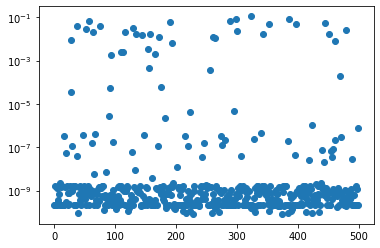

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(np.arange(0, config['neca']), p, marker='o')

ax.set_yscale('log')

In [25]:
data_eca_study = data_eca.sample(n=config['nbase'], replace=True, weights=p, 
                                 random_state=42)
data_eca_study.name = 'Optimized ECA Cohort'

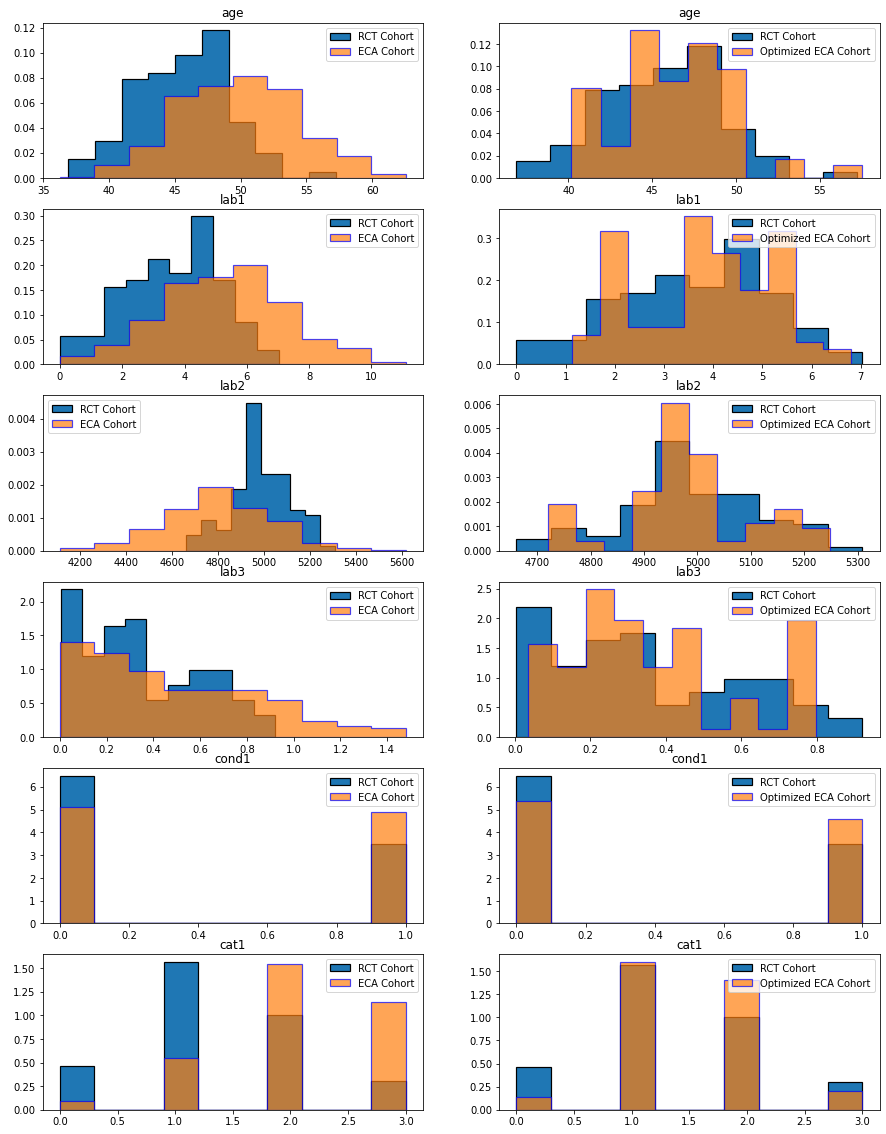

In [26]:
_, ax = plt.subplots(6,2, figsize=(15, 20))

for i, col in enumerate(data_base.columns):
    plot_dist(data_base, data_eca, col, ax[i][0])
    plot_dist(data_base, data_eca_study, col, ax[i][1])

In [19]:
for col in data_base.columns:
    print(f'Distribution of {col}')
    print('Before balancing', ks_2samp(data_base[col], data_eca[col]))
    print('After balancing', ks_2samp(data_base[col], data_eca_study[col]))
    print('\n')

Distribution of age
Before balancing KstestResult(statistic=0.438, pvalue=7.216449660063518e-15)
After balancing KstestResult(statistic=0.11, pvalue=0.5830090612540064)


Distribution of lab1
Before balancing KstestResult(statistic=0.428, pvalue=3.086420008457935e-14)
After balancing KstestResult(statistic=0.11, pvalue=0.5830090612540064)


Distribution of lab2
Before balancing KstestResult(statistic=0.49, pvalue=0.0)
After balancing KstestResult(statistic=0.12, pvalue=0.469506448503778)


Distribution of lab3
Before balancing KstestResult(statistic=0.202, pvalue=0.0019647665989825924)
After balancing KstestResult(statistic=0.19, pvalue=0.05390207893129876)


Distribution of cond1
Before balancing KstestResult(statistic=0.138, pvalue=0.07847565209171059)
After balancing KstestResult(statistic=0.15, pvalue=0.21117008625127576)


Distribution of cat1
Before balancing KstestResult(statistic=0.416, pvalue=1.9040324872321435e-13)
After balancing KstestResult(statistic=0.16, pvalue=0.1548386

In [20]:
for col in data_base.columns:
    print(f'Distribution of {col}')
    print('Before balancing', cohensd(data_base[col], data_eca[col]))
    print('After balancing', cohensd(data_base[col], data_eca_study[col]))
    print('\n')

Distribution of age
Before balancing -1.0430899275065018
After balancing 0.05236707652528327


Distribution of lab1
Before balancing -0.9540009154311554
After balancing 0.0035718117512571206


Distribution of lab2
Before balancing 0.9891339946893356
After balancing -0.06904639300456618


Distribution of lab3
Before balancing -0.4217791634577055
After balancing -0.18953741854864195


Distribution of cond1
Before balancing -0.28247036517513124
After balancing -0.3069867060579906


Distribution of cat1
Before balancing -0.9731322275730143
After balancing -0.321904718458577


